#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 16
**CH16A Predicting apartment prices with random forest**

using the airbnb dataset

version 0.92 2021-07-05

In [371]:
import os
import re
import sys
import warnings
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
from skimpy import skim

warnings.filterwarnings("ignore")


-------------------------------------------------------
### Import data

In [372]:

data_dir = "/Users/ghadena/Desktop/Business analytics/DA3/DA3/assignment_1/data/clean"
path = os.path.join(data_dir,'airbnb_madrid_cleaned.csv') 
data = pd.read_csv(path, index_col=0)


In [373]:
data.columns

Index(['scrape_id', 'source', 'host_id', 'host_name', 'host_since',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       ...
       ''toaster'', ''tv with amazon prime video'', ''tv with dvd player'',
       ''tv with hbo max'', ''tv'', ''varias body soap'',
       ''washer \\u2013\\u00a0in unit'', ''washer'', ''wifi'',
       ''wine glasses''],
      dtype='object', length=3217)

Keep if property type is Apartment, House or Townhouse

In [374]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26980 entries, 920645654779749874 to 1051480397972133254
Columns: 3217 entries, scrape_id to 'wine glasses'
dtypes: bool(1), float64(21), int64(3176), object(19)
memory usage: 662.2+ MB


In [375]:
import pandas as pd

# Define keyword-based mapping
property_mappings = {
    "Apartment": ["rental unit", "condo", "loft"],
    "House": ["home", "townhouse", "vacation home", "guesthouse", "chalet", "cabin", "bungalow", "villa", "cottage"],
    "Hotel/Serviced Stay": ["hotel", "serviced apartment", "boutique hotel", "bed and breakfast", "guest suite", "pension", "resort"],
    "Hostel": ["hostel"],
    "Traditional Stay": ["casa particular", "ryokan", "minsu"],
    "Alternative Stay": ["camper", "rv", "tiny home", "tent", "yurt", "cave", "dome", "barn", "earthen home", "religious building", "hut", "floor"],
    "Unknown": ["shared room", "entire place", "private room"],  # General category for shared spaces
}

# Function to assign property category
def categorize_property(property_type):
    property_type = str(property_type).lower()  # Ensure lowercase for comparison
    for category, keywords in property_mappings.items():
        if any(keyword in property_type for keyword in keywords):
            return category
    return "Unknown"  # Default category if no match is found

# Apply mapping function
data["property_category"] = data["property_type"].apply(categorize_property)

# Display the updated categories
property_category_counts = data["property_category"].value_counts()
print("Property Category Counts:\n", property_category_counts)

# Check remaining "Unknown" values
print("Property types classified as 'Unknown':")
print(data[data["property_category"] == "Unknown"]["property_type"].value_counts().head(20))

Property Category Counts:
 property_category
Apartment              23851
House                   1494
Hotel/Serviced Stay      889
Hostel                   388
Traditional Stay         236
Unknown                   70
Alternative Stay          52
Name: count, dtype: int64
Property types classified as 'Unknown':
property_type
Private room    48
Entire place    19
Shared room      3
Name: count, dtype: int64


In [376]:
import pandas as pd
import re

def clean_column_name(col):
    # Remove D_ prefix and any quotes/backslashes
    cleaned = re.sub(r'^d_[\'"]?|[\'"]$', '', col, flags=re.IGNORECASE)
    
    # Decode Unicode characters and special symbols
    cleaned = re.sub(r'\\u[0-9a-f]{4}', lambda m: bytes(m.group(0), 'utf-8').decode('unicode_escape'), cleaned)
    cleaned = re.sub(r'[^a-zA-Z0-9]', ' ', cleaned)  # Replace special chars with spaces
    
    # Standardize text
    cleaned = cleaned.lower().strip()
    cleaned = re.sub(r'\s+', '_', cleaned)  # Convert spaces to underscores
    cleaned = re.sub(r'[\s_]+', '', cleaned)  # Remove remaining whitespace
    
    return cleaned

# Apply to all columns
cleaned_columns = [clean_column_name(col) for col in data.columns]
data.columns = cleaned_columns 

In [377]:
aggregation_rules = {
    'shampoo': ['shampoo'],
    'conditioner': ['conditioner'],
    'body_soap': ['bodysoap'],
    'tv': ['tv', 'hdtv', 'television'],
    'streaming_services': ['netflix', 'amazonprime', 'hulu', 'disney+', 'streaming','appletv', 'chromecast','hbomax'],
    'refrigerator': ['refrigerator', 'fridge'],
    'stove': ['stove'],
    'child_friendly': ['child', 'baby', 'infant', 'toddler', 'highchair', 'crib', 'babybath', 'babymonitor', 'changingtable', 'children', 'kids', 'family'],
    'free_parking': ['free_parking', 'freeresidentialgarageonpremises', 'freestreetparking', 'freeparkingonpremises'],
    'paid_parking': ['paid_parking', 'paidparkingoffpremises','paidparkingonpremises','paid_garage'],
    'wifi': ['wifi', 'internet'],
    'bidet': ['bidet'],
    'oven': ['oven'],
    'cable': ['cable'],
    'sound_system': ['soundsystem', 'speaker'],
    'backyard': ['backyard', 'garden', 'yard'],
    'view': ['view'],
    'balcony': ['balcony'],
    'bbq': ['bbq'],
    'bathtub': ['bathtub'],
    'coffee_maker': ['coffee', 'espresso', 'keurig'],
    'excersise_equipment': ['excersise', 'freeweights', 'treadmill', 'elliptical', 'yoga', 'pilates','workoutbench','stationarybike'],
    'dryer': ['dryer', 'freedryer'],
    'washer': ['washer', 'freewasher'],
    'gym': ['gym'],
    'heating': ['heating','heated','centralheating'],
    'housekeeping_included': ['housekeeping', 'included', 'housekeepingavailable'],
    'housekeeping_extracost': ['housekeeping', 'extracost','housekeepingavailable'],
    'indoor_fireplace': ['indoorfireplace'],
    'paid_dryer_washer': ['paidwasher', 'paiddryer','laundromat'],
    'airconditioning': ['airconditioning', 'ac','centralairconditioning'],
    'kitchen': ['kitchen', 'kitchenette'],
    'game_console': ['gameconsole', 'playstation', 'xbox'],
    'clothing_storage': ['clothingstorage', 'closet', 'wardrobe', 'dresser'],
    'electric_car_charging': ['evcharger', 'freecarportonpremises'],
    'indoor_pool': ['indoorpool'],
    'outdoor_pool': ['outdoorpool','infinity','olympicsized','lappool','poolheathed'],
    'outdoor_space': ['outdoording','outdoorseating','outdoorshower','outdoorgrill','outdoorpatio','outdoorfirepit','outdoorbar','outdoorbarbecue','outdoorfurniture','outdoorplay'],
    'private_ameneties': ['private'],
    'shared_ameneties': ['shared'],
    'private_pool': ['privatepool'],
    'sauna': ['sauna','saunasteamroom','privatesauna'], 
    # Add more rules as needed...
}

In [378]:
import re

def aggregate_features(df, rules, strict_multi_word=None):
    """
    Aggregates binary features based on keyword matching in column names.
    
    - For `strict_multi_word` categories (e.g., housekeeping), ALL words must be present in the column name.
    - For everything else, a column matches if ANY keyword appears.
    
    Args:
        df (DataFrame): The dataset with binary dummy variables.
        rules (dict): Mapping of new feature names to keyword lists.
        strict_multi_word (list): List of category names that require ALL keywords in the column name.
    
    Returns:
        DataFrame: Updated dataset with aggregated features.
    """
    strict_multi_word = strict_multi_word or []  # Default to an empty list if None
    columns_to_drop = []  # List to track original columns for removal

    for new_col, keywords in rules.items():
        # Escape special regex characters in keywords
        patterns = [re.escape(k) for k in keywords]
        
        if new_col in strict_multi_word:
            # 🟢 Strict Mode: Ensure ALL keywords appear together (for housekeeping-related columns)
            matching_cols = [
                col for col in df.columns
                if all(re.search(p, col, flags=re.IGNORECASE) for p in patterns)
            ]
        else:
            # 🔵 Standard Mode: Match if ANY keyword appears (for all other features)
            pattern = r'(' + '|'.join(patterns) + r')'
            matching_cols = [
                col for col in df.columns
                if re.search(pattern, col, flags=re.IGNORECASE)
            ]
        
        print(f"\nCreating '{new_col}' from:")
        print(matching_cols)
        
        # Create new aggregated column
        if matching_cols:
            df[new_col] = df[matching_cols].any(axis=1).astype(int)
            columns_to_drop.extend(matching_cols)  # ✅ Track columns to remove
    
    print(f"Columns before dropping: {df.columns.tolist()}")
    
    # ✅ Drop the original detailed columns that were aggregated
    # ✅ FIX: Prevent Aggregated Columns from Being Dropped
    columns_to_drop = [col for col in columns_to_drop if col not in rules.keys()]
    df.drop(columns=columns_to_drop, inplace=True, errors="ignore")

    print(f"Final columns after dropping: {df.columns.tolist()}")
    
    return df


# 🔵 Housekeeping Columns Require **Both Words**
strict_categories = ['housekeeping_extra_cost', 'housekeeping_included']

# 🚀 Apply Aggregation
data = aggregate_features(data, aggregation_rules, strict_categories)

print(data.info())  # Shows data types and missing values
print(data.describe())  # Shows summary statistics for numeric columns


Creating 'shampoo' from:
['elvivedelorealshampoo', 'johnsonsbabyshampoo', 'loccitaneenprovenceshampoo', 'loralprimerasmarcasshampoo', 'loralshampoo', 'shampoo', 'shampoo', '3marcasdistintasshampoo', 'shampoo', 'shampoo', 'ademandashampoo', 'acondicionadorygeldeduchashampoo', 'aesopshampoo', 'almendraalmondsshampoo', 'almondshampoo', 'aloeverashampoo', 'alphaparfshampoo', 'alqvimiashampoo', 'amenitieshampoo', 'amenitiesdebienvenidashampoo', 'amenitiesdebienvenidashampoo', 'amenitiesshampoo', 'amenityshampoo', 'anyshampoo', 'anyahshampoo', 'apivitashampoo', 'aussieshampoo', 'avellanashampoo', 'avonshampoo', 'azlshampoo', 'bsicoshampoo', 'babariadecocoshampoo', 'basicoshampoo', 'bienvenueshampoo', 'bioshampoo', 'blancshampoo', 'blancashampoo', 'blancasshampoo', 'bodyplusshampoo', 'bonteshampoo', 'botededosotresdosisshampoo', 'camomilashampoo', 'carrefourshampoo', 'celadpendshampoo', 'champdeintensahidratacintresemmshampoo', 'champdepeloschwarkopfosimilarshampoo', 'champparaelcabelloshamp

In [379]:
# Find all duplicated column names
duplicate_columns = data.columns[data.columns.duplicated(keep=False)].tolist()

# Print value counts for each duplicate version of the column
for col in set(duplicate_columns):  # Ensure we check each unique name
    duplicate_indices = [i for i, name in enumerate(data.columns) if name == col]
    
    for index in duplicate_indices:
        print(f"\n🔹 Value Counts for '{col}' (Column Position {index}):")
        print(data.iloc[:, index].value_counts())


🔹 Value Counts for '' (Column Position 43):

0    26979
1        1
Name: count, dtype: int64

🔹 Value Counts for '' (Column Position 225):

0    26915
1       65
Name: count, dtype: int64

🔹 Value Counts for 'longtermstaysallowed' (Column Position 141):
longtermstaysallowed
0    16926
1    10054
Name: count, dtype: int64

🔹 Value Counts for 'longtermstaysallowed' (Column Position 254):
longtermstaysallowed
0    26978
1        2
Name: count, dtype: int64

🔹 Value Counts for 'iron' (Column Position 130):
iron
1    18198
0     8782
Name: count, dtype: int64

🔹 Value Counts for 'iron' (Column Position 250):
iron
0    26967
1       13
Name: count, dtype: int64

🔹 Value Counts for 'fireextinguisher' (Column Position 108):
fireextinguisher
0    19341
1     7639
Name: count, dtype: int64

🔹 Value Counts for 'fireextinguisher' (Column Position 240):
fireextinguisher
0    26977
1        3
Name: count, dtype: int64

🔹 Value Counts for 'lockonbedroomdoor' (Column Position 139):
lockonbedroomdoor


------------------------------------------------

In [319]:
# Extract Room Type (Entire, Private, Shared)
data["f_room_type"] = data["property_type"].str.extract(r"^(Entire|Private room|Shared room)")
# Fill missing values with "Unknown" before mapping
data["f_room_type"].fillna("Unknown", inplace=True)
print(data["f_room_type"].value_counts())


f_room_type
Entire          17422
Private room     8832
Unknown           383
Shared room       343
Name: count, dtype: int64


Room type as factor

In [320]:

data["f_property_type"] = data["property_category"].astype("category")
data["f_room_type"] = data["f_room_type"].astype("category")
data["f_room_type2"] = data["f_room_type"].map(
    {
        "Entire": "Entire/Apt",
        "Private room": "Private",
        "Shared room": "Shared",
        "Unknown": "Unknown"
    }
)
data["f_neighbourhood_cleansed"] = data["neighbourhood_cleansed"].astype("category")

---------

### Create Numerical variables

In [325]:
data["usd_price_day"] = data["price"]
data["p_host_response_rate"] = data["host_response_rate"].fillna(0).astype(int)
numericals = [
    "accommodates",
    "bathrooms",
    "review_scores_rating",
    "number_of_reviews",
    "reviews_per_month",
    "minimum_nights",
    "beds",
]
for col in numericals:
    data["n_" + col] = pd.to_numeric(data[col], errors="coerce")

Create days since first review

In [328]:
data["n_days_since"] = (
    data.calendar_last_scraped.apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
    - data.first_review.fillna("1950-01-01").apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d")
    )
).dt.days

data["n_days_since"] = np.where(data.first_review.isnull(), np.nan, data.n_days_since)


Create dummy vars

In [201]:
dummies = data.columns[44:-14]

Rename colunms

In [329]:
for col in dummies:
    data["d_" + (re.sub("/|\s|-", "", col)).replace("(s)", "s").lower()] = data[col]


Keep columns if contain d_, n_,f_, p_, usd_ and some others

In [330]:
data = pd.concat(
    [
        data.filter(
            regex="^d_.*|^n_.*|^f_.*|^p_.*|^usd_.*",
        ),
        data[
            [
                "price",
                "host_id",
                "neighbourhood_cleansed",
                "room_type",
                "property_type",
            ]
        ],
    ],
    axis=1,
)


### Take a look at price

In [331]:
#WHYYYYY DID HE FILTER FOR PRICE IF ITS OUR Y??? 

#data = data.loc[lambda x: x["price"] < 1000]


In [332]:
skim(data["price"].to_frame())

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 26980  │ │ float64     │ 1     │                                                          │
│ │ Number of columns │ 1      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name      ┃ NA     ┃ NA %     ┃ mean     ┃ sd       ┃ p0   ┃ p25   ┃ p50   ┃ p75  ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ price            │   6018 │    22.31 │    124.4 │    101.2 │    1 │    62 │   101 │  152 │   999 │   ▇▂    │  │
│ └──────────────────┴────────┴──────────┴──────────┴──────────┴──────┴───────┴───────┴──────┴───────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

<Axes: >

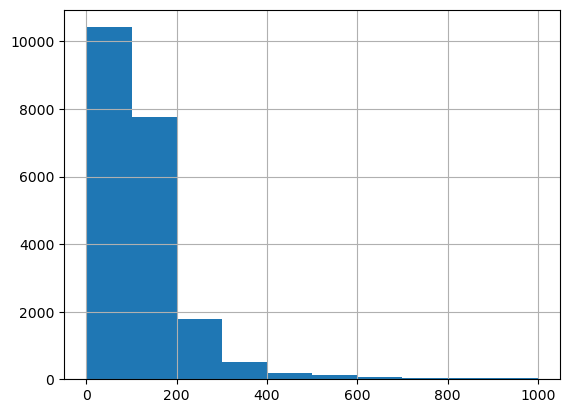

In [333]:
data["price"].hist()

<Axes: >

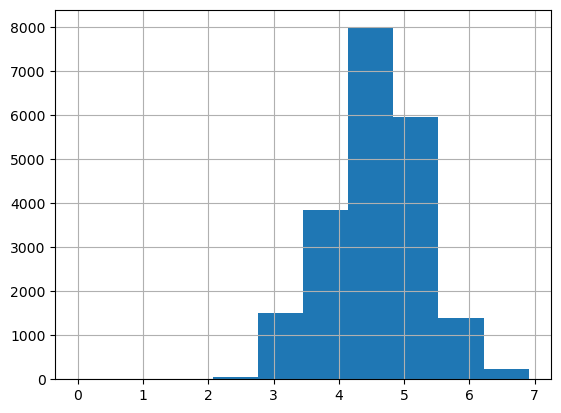

In [334]:
data["price"].apply(np.log).hist()

Squares and further values to create

In [335]:
data = data.assign(
    n_accommodates2=lambda x: x["n_accommodates"] ** 2,
    ln_accommodates=lambda x: np.log(x["n_accommodates"]),
    ln_accommodates2=lambda x: np.log(x["n_accommodates"]) ** 2,
    ln_beds=lambda x: np.log(x["n_beds"]),
    ln_number_of_reviews=lambda x: np.log(x["n_number_of_reviews"] + 1),
)


 Pool accomodations with 0,1,2,10 bathrooms

In [336]:
#creating a category for bathrooms 
bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 10)], closed="left")
f_bath = pd.cut(data["n_bathrooms"], bins=bins, labels=[0, 1, 2])
data["f_bathroom"] = f_bath
print(data["f_bathroom"].value_counts(dropna=False))

f_bathroom
[1.0, 2.0)     16107
NaN             5943
[2.0, 10.0)     4517
[0.0, 1.0)       413
Name: count, dtype: int64


Pool num of reviews to 3 categories: none, 1-51 and >51

In [337]:
bins = pd.IntervalIndex.from_tuples(
    [(0, 1), (1, 51), (51, max(data["n_number_of_reviews"]))], closed="left")
fnor = pd.cut(data["n_number_of_reviews"], bins=bins, labels=[0, 1, 2])
data["f_number_of_reviews"] = fnor
print(data["f_number_of_reviews"].value_counts(dropna=False))

f_number_of_reviews
[1.0, 51.0)       14643
[51.0, 1092.0)     6639
[0.0, 1.0)         5697
NaN                   1
Name: count, dtype: int64


Pool and categorize the number of minimum nights: 1,2,3, 3+

In [338]:
print("Max n_minimum_nights:", data["n_minimum_nights"].max())
print("Summary Statistics:\n", data["n_minimum_nights"].describe())
print("Unique values in n_minimum_nights:", data["n_minimum_nights"].unique())
#i assume those 3 extra values are outliers, so i will remove them
data = data[data["n_minimum_nights"] < 365] 

Max n_minimum_nights: 1125
Summary Statistics:
 count    26980.000000
mean         8.072090
std         30.823189
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max       1125.000000
Name: n_minimum_nights, dtype: float64
Unique values in n_minimum_nights: [ 120    5    2    3    1    7   15   30  365   90   28   21   32    4
   31   12    6   20    8   29   14   18   25   50   10   13   27  300
   60  180   45  100   99   35    9  360   75   23 1125   84   68  333
   95   19  200  160   46   17  330  600   38   70 1000   16   59   33
   80   40   65   26  110   91   69   22  179   24  150   39  305   11
   34  999  225  750 1100   61  148  364  140   55  220  700   58  400
  240   54  289  222   56   62]


In [339]:
bins = pd.IntervalIndex.from_tuples(
    [(1, 2), (2, 3), (3, max(data.n_minimum_nights))], closed="left"
)
f_min_n = pd.cut(data["n_minimum_nights"].to_list(), bins, labels=["1", "2", "3"])
data["f_minimum_nights"] = f_min_n
data["f_minimum_nights"].value_counts(dropna=False)

f_minimum_nights
[1.0, 2.0)      11722
[3.0, 364.0)     9816
[2.0, 3.0)       5393
NaN                 1
Name: count, dtype: int64

Change Infinite values with NaNs

In [340]:
data = data.replace([np.inf, -np.inf], np.nan)

___

Where do we have missing variables now?

In [341]:
data.isnull().sum().loc[lambda x: x > 0]

usd_price_day             5982
n_bathrooms               5905
n_review_scores_rating    5678
n_reviews_per_month       5678
n_beds                    5927
n_days_since              5678
price                     5982
ln_beds                   6386
f_bathroom                5908
f_number_of_reviews          1
f_minimum_nights             1
dtype: int64

What to do with missing values?

1. drop if no target

In [342]:
data = data.loc[lambda x: x["price"].notnull()]

2. imput when few, not that important

In [343]:
# Ensure 'n_accommodates' has no missing values before using it in 'n_beds'
data["n_accommodates"] = data["n_accommodates"].fillna(data["n_accommodates"].median())

# Fix categorical columns by adding "99" as a category before filling NaNs
for col in ["f_bathroom", "f_minimum_nights", "f_number_of_reviews"]:
    if col in data.columns and pd.api.types.is_categorical_dtype(data[col]):
        data[col] = data[col].cat.add_categories([99]).fillna(99)  # Add category & fill NaNs
    else:
        data[col] = data[col].fillna(99)  # If not categorical, fill normally

# Assign and fill missing values in a single step
data = data.assign(
    n_bathrooms=lambda x: x["n_bathrooms"].fillna(np.median(x["n_bathrooms"].dropna())),
    n_beds=lambda x: np.where(x["n_beds"].isnull(), x["n_accommodates"], x["n_beds"]),
    ln_beds=lambda x: x["ln_beds"].fillna(0),
)

In [344]:
data.isnull().sum().loc[lambda x: x > 0]

n_review_scores_rating    3515
n_reviews_per_month       3515
n_days_since              3515
dtype: int64

 4. Replace missing variables re reviews with zero, when no review + add flags

In [345]:
data = data.assign(
    flag_days_since=np.multiply(data["n_days_since"].isnull(), 1),
    n_days_since=data["n_days_since"].fillna(np.median(data["n_days_since"].dropna())),
    flag_review_scores_rating=np.multiply(data["n_review_scores_rating"].isnull(), 1),
    n_review_scores_rating=data["n_review_scores_rating"].fillna(
        np.median(data["n_review_scores_rating"].dropna())
    ),
    flag_reviews_per_month=np.multiply(data["n_reviews_per_month"].isnull(), 1),
    n_reviews_per_month=data["n_reviews_per_month"].fillna(
        np.median(data["n_reviews_per_month"].dropna())
    ),
    flag_n_number_of_reviews=np.multiply(data["n_number_of_reviews"].isnull(), 1),
)

In [346]:
data.flag_days_since.value_counts()


flag_days_since
0    17435
1     3515
Name: count, dtype: int64


Redo features

Create variables, measuring the time since: squared, cubic, logs

In [347]:
data = data.assign(
    ln_days_since=lambda x: np.log(x["n_days_since"] + 1),
    ln_days_since2=lambda x: np.log(x["n_days_since"] + 1) ** 2,
    ln_days_since3=lambda x: np.log(x["n_days_since"] + 1) ** 3,
    n_days_since2=lambda x: x["n_days_since"] ** 2,
    n_days_since3=lambda x: x["n_days_since"] ** 3,
    ln_review_scores_rating=lambda x: np.log(x["n_review_scores_rating"]),
)


In [348]:
data["n_days_since"] = data["ln_days_since"].fillna(0)
data["ln_days_since2"] = data["ln_days_since2"].fillna(0)
data["ln_days_since3"] = data["ln_days_since3"].fillna(0)

In [349]:
data.isnull().sum().loc[lambda x: x > 0]

Series([], dtype: int64)

In [350]:
data.describe()


,usd_price_day,p_host_response_rate,n_accommodates,n_bathrooms,n_review_scores_rating,n_number_of_reviews,n_reviews_per_month,n_minimum_nights,n_beds,n_days_since,...,flag_days_since,flag_review_scores_rating,flag_reviews_per_month,flag_n_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating
count,20950.000000,20950.0,20950.000000,20950.000000,20950.000000,20950.000000,20950.000000,20950.000000,20950.000000,20950.000000,...,20950.00000,20950.00000,20950.00000,20950.0,20950.000000,20950.000000,20950.000000,2.095000e+04,2.095000e+04,20950.000000
mean,124.330931,0.0,3.233126,1.294224,4.668044,53.653986,1.948632,6.921050,1.962530,6.289787,...,0.16778,0.16778,0.16778,0.0,6.289787,40.979314,274.169714,1.738475e+06,4.496552e+09,1.533862
std,101.006194,0.0,1.915831,0.659168,0.428162,93.887664,1.836324,17.117185,1.483494,1.190781,...,0.37368,0.37368,0.37368,0.0,1.190781,13.984320,131.721648,3.242997e+06,1.162121e+10,0.135895
min,1.000000,0.0,1.000000,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,62.000000,0.0,2.000000,1.000000,4.610000,2.000000,0.740000,1.000000,1.000000,5.717028,...,0.00000,0.00000,0.00000,0.0,5.717028,32.684406,186.857653,9.180900e+04,2.781813e+07,1.528228
50%,101.000000,0.0,3.000000,1.000000,4.760000,16.000000,1.460000,2.000000,2.000000,6.388561,...,0.00000,0.00000,0.00000,0.0,6.388561,40.813717,260.740936,3.528360e+05,2.095846e+08,1.560248
75%,152.000000,0.0,4.000000,1.500000,4.880000,62.000000,2.560000,3.000000,2.000000,7.036148,...,0.00000,0.00000,0.00000,0.0,7.036148,49.507386,348.341317,1.290496e+06,1.466003e+09,1.585145
max,999.000000,0.0,16.000000,12.000000,5.000000,1092.000000,41.220000,364.000000,40.000000,8.546364,...,1.00000,1.00000,1.00000,0.0,8.546364,73.040330,624.229217,2.649161e+07,1.363523e+11,1.609438


In [351]:
#skim(data)

In [352]:
#data.to_csv("data/airbnb_madrid_workfile_adj.csv", index=False)